## Initial setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/masters/app1

/content/drive/My Drive/masters/app1


In [ ]:
!pip install scattertext datasets transformers[torch] tqdm accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 

## Preliminary data inspection

### Loading the data

In [ ]:
import scattertext as st
import pandas as pd

from collections import Counter

In [ ]:
# distinguishes between implicit_hate|explicit_hate|not_hate
df_class = pd.read_csv('data/implicit_hate_v1_stg1_posts.tsv', sep="\t")

# distinguishes between fine-grained implicit_hate classes
df_implicit_class = pd.read_csv('data/implicit_hate_v1_stg2_posts.tsv', sep="\t")

# includes generated implied statements & target groups
df_statements = pd.read_csv('data/implicit_hate_v1_stg3_posts.tsv', sep="\t")

First, we will focus on the contents of the initial dataset. This focus will facilitate our primary objective, which is discerning implicit hate (`implicit_hate` class) from explicit hate (`explicit_hate`) or content that is not hateful (`not_hate`).

In [ ]:
df_class.head()

post          class
0    " : jewish harvard professor noel ignatiev w...  implicit_hate
1   b.higher education is a part of european cult...       not_hate
2   has a problem with  " the whites " " and " " ...       not_hate
3   is yasir qadhi a hate preacher for calling ch...       not_hate
4   rt  " : how three million germans mass murder...       not_hate

### Class distributions

In [ ]:
class_distribution = Counter(df_class["class"])
print(class_distribution)

hate_no_hate = {'not_hate': class_distribution.get('not_hate', 0), 'hate': class_distribution.get('implicit_hate', 0) + class_distribution.get('explicit_hate', 0)}
hate_type = {'implicit_hate': class_distribution.get('implicit_hate', 0), 'explicit_hate': class_distribution.get('explicit_hate', 0)}

Counter({'not_hate': 13291, 'implicit_hate': 7100, 'explicit_hate': 1089})


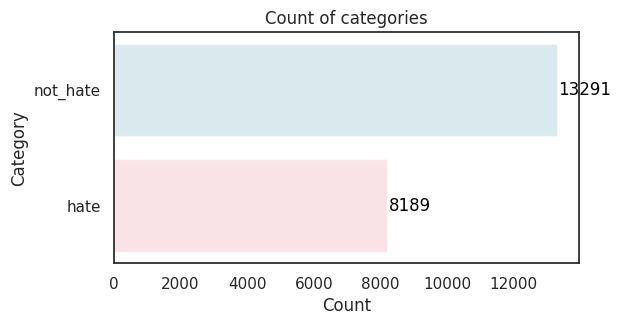

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

categories_hnh = hate_no_hate.keys()
values_hnh = hate_no_hate.values()

# Create the horizontal barplot
sns.set(style="white")
plt.figure(figsize=(6, 3))  # Adjust the figure size
barplot = sns.barplot(x=values_hnh, y=categories_hnh, hue=categories_hnh, palette=['lightblue', 'pink'], alpha=0.5, legend=False)

# Add numbers on the bars
for i, v in enumerate(values_hnh):
    barplot.text(v + 50, i, str(v), color='black', ha='left', va='center')

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Count of categories')

# Show the plot
plt.show()

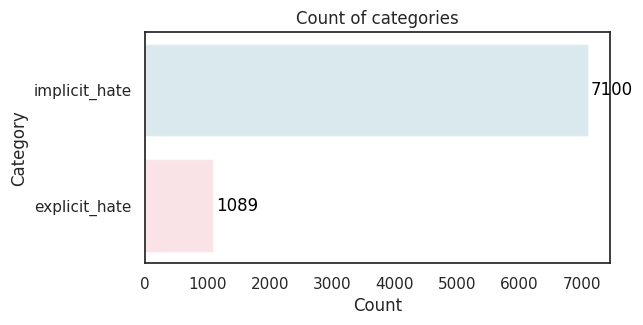

In [ ]:
categories_ht = hate_type.keys()
values_ht = hate_type.values()

# Create the horizontal barplot
sns.set(style="white")
plt.figure(figsize=(6, 3))  # Adjust the figure size
barplot = sns.barplot(x=values_ht, y=categories_ht, hue=categories_ht, palette=['lightblue', 'pink'], alpha=0.5, legend=False)

# Add numbers on the bars
for i, v in enumerate(values_ht):
    barplot.text(v + 50, i, str(v), color='black', ha='left', va='center')

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Count of categories')

# Show the plot
plt.show()

After checking everything was loaded correctly, we checked the class distribution for this dataset, which turned out to be rather unbalanced, especially considering the examples of explicit hate versus implicit.

In [ ]:
implicit_class_distribution = Counter(df_implicit_class["implicit_class"])
print(implicit_class_distribution)

implicit_type = dict(implicit_class_distribution)

Counter({'white_grievance': 1538, 'incitement': 1269, 'stereotypical': 1133, 'inferiority': 863, 'irony': 797, 'threatening': 666, 'other': 80})


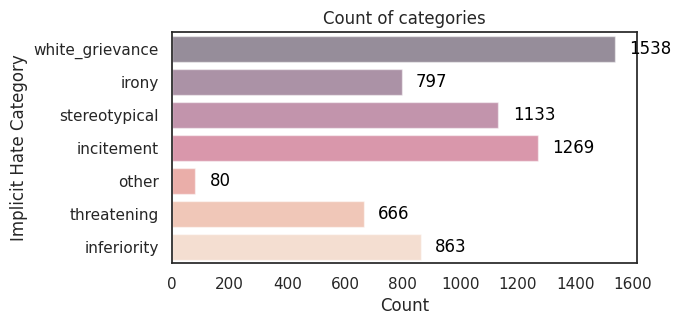

In [ ]:
categories_imp = implicit_type.keys()
values_imp = implicit_type.values()

# Create the horizontal barplot
sns.set(style="white")
plt.figure(figsize=(6, 3))  # Adjust the figure size
barplot = sns.barplot(x=values_imp, y=categories_imp, hue=categories_imp, palette='rocket', alpha=0.5)

# Add numbers on the bars
for i, v in enumerate(values_imp):
    barplot.text(v + 50, i, str(v), color='black', ha='left', va='center')

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Implicit Hate Category')
plt.title('Count of categories')

# Show the plot
plt.show()

For the second dataset (implicit-only) things are looking better in terms of class balance excluding the `other` category, which will be also excluded from training and metrics. Since we won't use the third dataset for classification, let's delve into corpus analysis first for more revealing insights.

### Corpus analysis with Scattertext

Scattertext is an useful tool for corpus analysis where we can compare which words are more prevalent in each of two categories. Since we have three classes, we are going to compare only the combinations of two we deemed more interesting: `implicit_hate` vs `not_hate` and `implicit_hate` vs `explicit_hate`.

In [ ]:
no_subset = df_class[df_class['class'] == "not_hate"]
im_subset = df_class[df_class['class'] == "implicit_hate"]
ex_subset = df_class[df_class['class'] == "explicit_hate"]

# df implicit_hate + not_hate
df_im_no = pd.concat([no_subset, im_subset], ignore_index=True)

# df implicit_hate + explicit_hate
df_im_ex = pd.concat([im_subset, ex_subset], ignore_index=True)

In [ ]:
corpus_im_no = st.CorpusFromPandas(
    df_im_no,
    category_col='class',
    text_col='post',
    nlp=st.whitespace_nlp_with_sentences).build()

html_im_no = st.produce_scattertext_explorer(
    corpus_im_no,
    category='implicit_hate',
    category_name='implicit_hate',
    not_category_name='not_hate',
    width_in_pixels=1000)

open('im_no_visualization.html', 'wb').write(html_im_no.encode('utf-8'))

In [ ]:
from IPython.display import HTML

# Read the HTML content from the file
html_content = open('im_no_visualization.html', 'r', encoding='utf-8').read()

# Display the HTML content in the notebook
HTML(html_content)

The analysis shows words mostly associated with **implicit hate** are either names of target groups - rarely any slurs (although we might consider some subtle exceptions, such as the frequent mention of *savages*) or explicitly hateful denominations. The most "explicit" term that appears in this category is *white genocide* which is usually related to certain hateful groups, although still requires a baseline level of political context to understand its usage connotations.

Regarding **non hate** terms, the dataset mostly comprises concepts associated with politics, which probably indicate an origin from news sources or merely informative content rather than coming from actual personal opinions.

In [ ]:
corpus_im_ex = st.CorpusFromPandas(
    df_im_ex,
    category_col='class',
    text_col='post',
    nlp=st.whitespace_nlp_with_sentences).build()

html_im_ex = st.produce_scattertext_explorer(
    corpus_im_ex,
    category='implicit_hate',
    category_name='implicit_hate',
    not_category_name='explicit_hate',
    width_in_pixels=1000)

open('im_ex_visualization.html', 'wb').write(html_im_ex.encode('utf-8'))

In [ ]:
html_content = open('im_ex_visualization.html', 'r', encoding='utf-8').read()
HTML(html_content)

Here the graph essentially speaks for itself, so much that in the case of **implicit hate** it is mostly stopwords and again mentions to target groups. A first glance at **explicit hate** reveals a lot - it's hard to find something that is not an insult or inappropiate language.

### Target groups analysis

In this section we will use the dataset that ElSherief et al. generated as a result of asking a generative text model the possible targets of each **implicit hate** tweet. Note that target does not necessarily imply being the target of actual *hate* (more details on our report).

In [ ]:
# convert all targets to lowercase, since there's different casings
targets = [str(target).lower() for target in df_statements["target"]]

# group all synonym target names into broader categories
grouped_targets = []
for i in targets:
  if i in ["white people", "white", "white men", "white folk", "white folks", "whites"]:
    i = "white people"
    grouped_targets.append(i)
  elif i in ["black people", "black men", "black folk", "black", "black folks", "blacks", "africans"]:
    i = "black people"
    grouped_targets.append(i)
  elif i in ["muslim", "islamic people", "islamic", "islamists", "arabs"]:
    i = "muslims"
    grouped_targets.append(i)
  elif i in ["jew", "jewish", "jewish people"]:
    i = "jews"
    grouped_targets.append(i)
  elif i in ["non-white", "non white", "people of color", "non whites", "non-whites"]:
    i = "non-white people"
    grouped_targets.append(i)
  elif "immigrant" in i or "illegal" in i:
    i = "immigrants"
    grouped_targets.append(i)
  elif i in ["homosexual", "gay", "gay people", "gay folk", "gays"] or ("lgbt" in i and "anti" not in i) or "trans" in i or "lesbian" in i:
    i = "LGBTQ+"
    grouped_targets.append(i)
  elif "conservative" in i or "republican" in i:
    i = "conservatives"
    grouped_targets.append(i)
  elif "liberal" in i or "progressive" in i or "left" in i or "democrat" in i:
    i = "liberals"
    grouped_targets.append(i)
  elif "mexic" in i:
    i = "mexicans"
    grouped_targets.append(i)
  elif "wom" in i:
    i = "women"
    grouped_targets.append(i)
  elif "specifi" in i:
    pass
  else:
    grouped_targets.append(i)

targets_count = Counter(grouped_targets)
print(targets_count)

Counter({'white people': 1047, 'immigrants': 1015, 'minorities': 742, 'muslims': 665, 'black people': 651, 'jews': 506, 'non-white people': 347, 'liberals': 331, 'conservative': 111, 'LGBTQ+': 58, 'women': 50, 'mexicans': 34, 'christians': 19, 'antifa': 15, 'germans': 13, 'refugees': 12, 'indians': 10, 'americans': 10, 'arabians': 9, 'feminists': 9, 'hispanics': 9, 'journalists': 9, 'hindus': 8, 'southerners': 8, 'media': 7, 'white nationalists': 7, 'black lives matter': 7, 'iranians': 7, 'asian folks': 7, 'latino folks': 7, 'police': 6, 'foreigners': 6, 'cops': 6, 'religious people': 6, 'politicians': 5, 'white supremacists': 5, 'poor people': 5, 'asians': 5, 'rich people': 5, 'black people.': 5, 'criminals': 5, 'anti-whites': 4, 'latinos': 4, 'white christians': 4, 'white males': 4, 'communists': 4, 'russians': 4, 'black lives matter supporters': 4, 'gay folks': 4, 'blm': 3, 'israelis': 3, 'intellectuals': 3, 'alt-right': 3, 'brown people': 3, 'white nationalist': 3, 'multiracials': 

In [ ]:
import plotly.graph_objects as go

targets_count = dict(sorted(targets_count.items(), key=lambda x: x[1], reverse=True))
first_15_targets = {key: targets_count[key] for key in list(targets_count)[:15]}

fig=go.Figure(
    data=[go.Scatter(
    x=list(first_15_targets.keys()),
    y=list(first_15_targets.values()),
    mode='markers',
    marker=dict(
        color=list(first_15_targets.values()),
        size=[75, 75, 70, 60, 50, 50, 45, 45, 40, 35, 30, 25, 20, 20, 15],
        showscale=True
      )
)])

fig.update_layout(
    title='Count of each target group',
    xaxis=dict(title='Target group'),
    yaxis=dict(title='Count'),
    title_x=0.5,
    title_y=0.9
)

fig.show()

We observe *white people* is the biggest target group. This might seem surprising, but it is explained by the fact we just mentioned in the introduction of this subsection. Upon further examination of the data, it can be seen they are usually not the recipients of hate, but rather are frequently mentioned within hateful comments - i.e. *We must secure the existence of our people and a future for white children.*

Regarding the other target groups which we tried to merge in a more fine-grained way, more expected groups appear such as minorities and opposed political factions.

## Classification

### Binary classification: *Implicit hate speech* vs *non-hate*

Considering how much the `explicit_hate` class is underrepresented, we have concluded getting rid of all the documents annotated as such, as it will only add noise - and it defeats our main objective, which is detecting implicit hate patterns.

We finetuned a distilBERT model for this task with our first dataset.
Implementation specifics are discussed in deeper detail in our report as well. Results include the four standard metrics for classification tasks and a confusion matrix.

In [ ]:
# remove explicit_hate documents
df_class = df_class.rename(columns={'class': 'label'})
df_class = df_class[df_class['label'] != 'explicit_hate']

# binarize labels
df_class['label'] = df_class['label'].apply(lambda x: 1 if x == 'implicit_hate' else 0)  # do not run again!

# separate predictors and predicted variables
posts = df_class.post.values
labels = df_class.label.values

In [ ]:
# import tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# preliminary tokenization to calculate optimal max_length
max_post_length = 0
for post in posts:
    input_ids = tokenizer.encode(post)

    # Update the maximum sentence length.
    max_post_length = max(max_post_length, len(input_ids))

# set to the nearest power of 2
max_token_length = 2 ** (len(bin(max_post_length)) - 2)
print("Maximum number of tokens in our dataset:", max_post_length)
print("Max token length allowed:", max_token_length)

Maximum number of tokens in our dataset: 189
Max token length allowed: 256


In [ ]:
import torch

# actual tokenization
input_ids, attention_masks = [], []  # accumulators

for post in posts:
    # tokenizer with encoder_plus, which adds special tokens & generates attention masks
    encoded_data = tokenizer.encode_plus(
                        post,
                        add_special_tokens = True,  # add '[CLS]' and '[SEP]'
                        max_length = max_token_length,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',  # return pytorch tensors for training
                   )

    # save the encoded tweet & its attention masks in each list
    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])

# lists to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# check tokenization worked as expected
print('Tweet: ', posts[0])
print('Token IDs:', input_ids[0])
print(type(input_ids))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Tweet:    " : jewish harvard professor noel ignatiev wants to abolish the white race via #wr " " "
Token IDs: tensor([  101,  1000,  1024,  3644,  5765,  2934, 10716, 16270, 10450,  6777,
         4122,  2000, 11113, 20872,  2232,  1996,  2317,  2679,  3081,  1001,
        23277,  1000,  1000,  1000,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    

In [ ]:
# perform splits
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# 60 - 20 - 20 split // set a seed
train_dataset, validation_dataset, test_dataset = random_split(dataset, [0.6, 0.2, 0.2], torch.Generator().manual_seed(42))

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(validation_dataset)}')
print(f'Testing samples: {len(test_dataset)}')

Training samples: 12235
Validation samples: 4078
Testing samples: 4078


In [ ]:
from torch.utils.data import DataLoader

# create dataloaders from splits
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # batch training data!
validation_loader = DataLoader(validation_dataset, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=True)

In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# load model for binary classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2, return_dict=False)

In [ ]:
from tqdm import tqdm

# run on GPU if there's a GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# hyperparameters
epochs = 4
total_steps = len(train_loader) * epochs
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# training (fine-tuning) loop
print('Training...')
for epoch in range(0, epochs):
    print("-------------------------------")

    # reset the total training loss for each epoch
    training_loss = 0
    correct_predictions = 0
    total_predictions = 0
    model.train()

    # for each batch of training data...
    training_progress = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, batch in training_progress:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        loss, logits = model(b_input_ids,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        training_loss += loss.item()

        # compute accuracy
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == b_labels).item()
        total_predictions += b_labels.size(0)

        # perform a backward pass to calculate the gradients
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # prevent exploding gradients
        optimizer.step()

        # update the learning rate according to scheduler
        scheduler.step()

        # add description to updater (with loss data)
        training_progress.set_description(f'Epoch [{epoch+1}/{epochs}], Batch [{step+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_accuracy = correct_predictions / total_predictions
    print(f"Epoch [{epoch+1}/{epochs}], Train accuracy: {epoch_accuracy:.4f}")

    # validation loop (updates per epoch)
    print("")
    print('Running validation...')

    # reset variables & put the model in evaluation mode
    evaluation_loss = 0
    correct_predictions_val = 0
    total_predictions_val = 0
    model.eval()

    # evaluate data epoch by epoch
    validation_progress = tqdm(validation_loader, total=len(validation_loader))
    for batch in validation_progress:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for training
        with torch.no_grad():
            (loss, logits) = model(b_input_ids,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # accumulate validation loss
        evaluation_loss += loss.item()

        # compute accuracy
        predicted_labels_val = torch.argmax(logits, dim=1)
        correct_predictions_val += torch.sum(predicted_labels_val == b_labels).item()
        total_predictions_val += b_labels.size(0)

    # calculate accuracy for the epoch
    epoch_accuracy_val = correct_predictions_val / total_predictions_val
    print(f"Validation Accuracy: {epoch_accuracy_val:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training...
-------------------------------


Epoch [1/4], Batch [765/765], Loss: 0.1505: 100%|██████████| 765/765 [04:25<00:00,  2.88it/s]


Epoch [1/4], Train accuracy: 0.8258

Running validation...


100%|██████████| 4078/4078 [00:36<00:00, 110.36it/s]


Validation Accuracy: 0.7815
-------------------------------


Epoch [2/4], Batch [765/765], Loss: 0.1235: 100%|██████████| 765/765 [04:23<00:00,  2.90it/s]


Epoch [2/4], Train accuracy: 0.8955

Running validation...


100%|██████████| 4078/4078 [00:40<00:00, 99.75it/s] 


Validation Accuracy: 0.7751
-------------------------------


Epoch [3/4], Batch [765/765], Loss: 0.1321: 100%|██████████| 765/765 [04:23<00:00,  2.90it/s]


Epoch [3/4], Train accuracy: 0.9430

Running validation...


100%|██████████| 4078/4078 [00:37<00:00, 109.33it/s]


Validation Accuracy: 0.7783
-------------------------------


Epoch [4/4], Batch [765/765], Loss: 0.0017: 100%|██████████| 765/765 [04:23<00:00,  2.91it/s]


Epoch [4/4], Train accuracy: 0.9682

Running validation...


100%|██████████| 4078/4078 [00:37<00:00, 109.08it/s]

Validation Accuracy: 0.7734


## TEST SET: RELEVANT METRICS ##
Accuracy: 0.7668
Precision: 0.6886
Recall: 0.6192
F1-score: 0.6520
------------------------------------


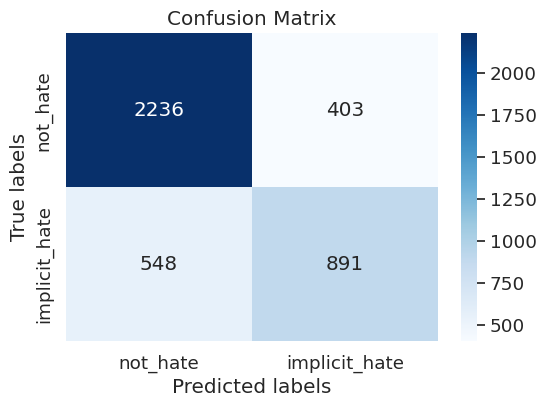

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def generate_confusion_matrix(model, test_loader, device):
    # accumulators & put the model in evaluation mode
    true_labels, predicted_labels = [], []
    model.eval()

    # Iterate over the test data loader to collect true and predicted labels
    with torch.no_grad():
        for batch in test_loader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # forward pass
            logits = model(b_input_ids, attention_mask=b_input_mask)
            predicted_labels_batch = torch.argmax(logits[0], dim=1)

            # append true and predicted labels to the lists
            true_labels.extend(b_labels.cpu().numpy())
            predicted_labels.extend(predicted_labels_batch.cpu().numpy())

    # compute confusion matrix
    confusion_matrix_array = confusion_matrix(true_labels, predicted_labels)

    # compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print("## TEST SET: RELEVANT METRICS ##")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("------------------------------------")

    # plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(confusion_matrix_array, annot=True, fmt='d', cmap='Blues',
                     xticklabels=['not_hate', 'implicit_hate'], yticklabels=['not_hate', 'implicit_hate'])
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

    return confusion_matrix_array

confusion_matrix_array = generate_confusion_matrix(model, test_loader, device)

### Fine-grained classification: *Implicit hate categories*

Here we followed a similar procedure as in the previous subsection, only training directly with HuggingFace libraries instead of lower-level PyTorch. Results with confusion matrices below.

In [ ]:
from datasets import Dataset, DatasetDict

# copy IHC2 dataframe
df = df_implicit_class.copy()

# remove the column 'extra_implicit_class' & documents with 'other' as 'implicit_class'
df.drop(columns=['extra_implicit_class'], inplace=True)
df = df[df['implicit_class'] != 'other']

# map labels to numbers and create a HuggingFace dataset
label_map = {
    'white_grievance': 0,
    'irony': 1,
    'stereotypical': 2,
    'incitement': 3,
    'threatening': 4,
    'inferiority': 5
}
df['implicit_class'] = df['implicit_class'].map(label_map)

# list the columns for the HuggingFace dataset
# rename columns
df.rename(columns={'post': 'text', 'implicit_class': 'labels'}, inplace=True)
columns = ['text', 'labels']

# create the HuggingFace dataset (dict)
hf_dataset = Dataset.from_pandas(df[columns]).train_test_split(test_size=0.2)
print(hf_dataset["test"][0])

{'text': 'best decision a jew could make to further the cause of white aryan genocide.make him take a lie detector test', 'labels': 0, '__index_level_0__': 1785}


In [ ]:
# old tokenizer still valid, tokenize
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=max_token_length)  # 256

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5012 [00:00<?, ? examples/s]

Map:   0%|          | 0/1254 [00:00<?, ? examples/s]

In [ ]:
# reinstantiate model from clean pretrained checkpoint
from transformers import AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

model_2 = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=6)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# metric accumulator for traineing loop
def compute_metrics(eval_pred, label_map=None):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # calculate accuracy, precision, recall, f1 (macro avgs)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
from transformers import TrainingArguments, Trainer

# for trainer class
args = TrainingArguments(
    f"/content/drive/My Drive/masters/app1",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model_2,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
# train the model!
trainer.train()

Checkpoint destination directory /content/drive/My Drive/masters/app1/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=942, training_loss=0.054843244532364444, metrics={'train_runtime': 372.3082, 'train_samples_per_second': 40.386, 'train_steps_per_second': 2.53, 'total_flos': 995960944226304.0, 'train_loss': 0.054843244532364444, 'epoch': 3.0})

In [ ]:
# perform evaluation on test set
trainer.evaluate()

{'eval_loss': 2.4696319103240967,
 'eval_accuracy': 0.6012759170653907,
 'eval_precision': 0.6097390038018368,
 'eval_recall': 0.5975435653769308,
 'eval_f1': 0.6025299274104047,
 'eval_runtime': 9.7232,
 'eval_samples_per_second': 128.97,
 'eval_steps_per_second': 8.125,
 'epoch': 3.0}

In [ ]:
# with predict, we can extract ground truths for cm
predictions = trainer.predict(tokenized_datasets["test"])
true_labels = predictions.label_ids
predicted_labels = predictions.predictions.argmax(axis=1)

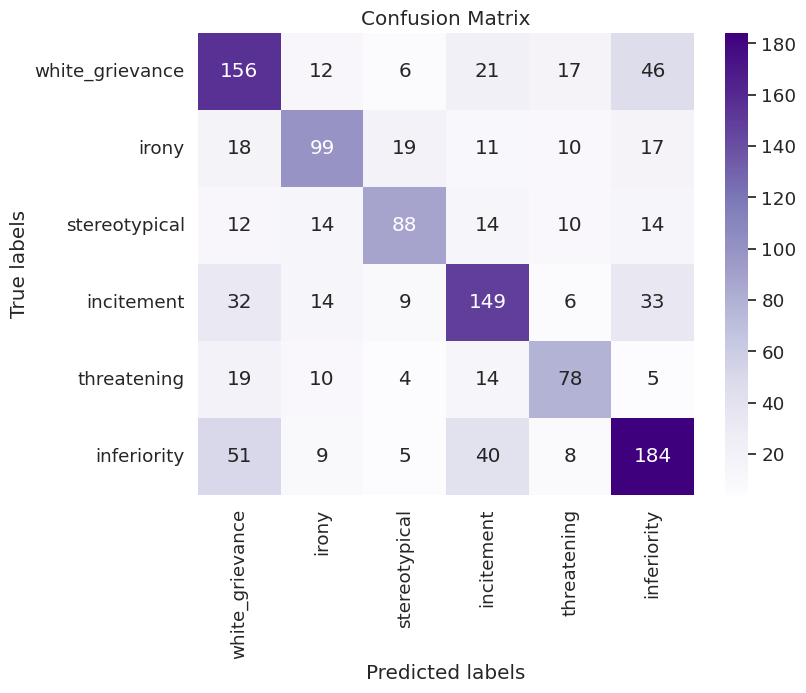

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# transform true and predicted labels using our previously instantiated label map
true_labels_transformed = [label_map[label] for label in true_labels]
predicted_labels_transformed = [label_map[label] for label in predicted_labels]

# compute the confusion matrix
confusion_matrix_array = confusion_matrix(true_labels_transformed, predicted_labels_transformed)

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(confusion_matrix_array, annot=True, fmt='d', cmap='Purples',
                 xticklabels=label_map.values(), yticklabels=label_map.values())
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

## Challenges: Irony detection

In our reference paper, irony detection is highlighted as one of the challenges that require further exploration.

Curious about this issue, we conducted inference experiments using a pretrained model for irony detection from HuggingFace called [twitter-roberta-base-irony](ttps://huggingface.co/cardiffnlp/twitter-roberta-base-irony) with tweets tagged as irony from our second dataset.

In [ ]:
data_raw = df_implicit_class.copy()

In [ ]:
# extract all the irony sentences
all_ir = []
for i in range(len(data_raw['implicit_class'])):
  if data_raw['implicit_class'][i] == "irony":
    all_ir.append(data_raw['post'][i])
print(f"Total [implicitly hateful] posts tagged as 'irony': {len(all_ir)}")

Total [implicitly hateful] posts tagged as 'irony': 797


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

task = 'irony'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# import models
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# inference loop
def predict_irony(examples):
    wro_ir = []
    for i in tqdm(examples):
        text = preprocess(i)
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)  # two numbers in scores: non-irony score vs irony score

        if scores[0] > scores[1]:  # if non-irony score is bigger than irony, we save it
          wro_ir.append(i)

    return wro_ir

In [ ]:
# whole prediction will take around 1-2 mins with T4 GPU
wro_ir = predict_irony(all_ir)
print(f"Irony detection accuracy: {1-(len(wro_ir)/len(all_ir))}")

100%|██████████| 797/797 [02:51<00:00,  4.63it/s]

Irony detection accuracy: 0.44918444165621074


We can see BERT fails to grasp the irony in our set more than half of the time. But most of the 'irony' posts are posed as direct questions...

In [ ]:
q_ir = [i for i in all_ir if "?" in i]
wro_q_ir = predict_irony(q_ir)
print(f"\nIrony detection accuracy (with direct questions): {1-(len(wro_q_ir)/len(q_ir))}")

100%|██████████| 357/357 [01:09<00:00,  5.16it/s]


Irony detection accuracy (with direct questions): 0.27450980392156865


As we suspected, the irony detection accuracy (from 45% to 27%) is even lower when tested the model for inference with direct questions. What if we transformed those questions into affirmative sentences? Will it understand better?

So, we modified the undetected questions according to the following rules:

**(1) Do not correct grammatical errors.** Some of these tweets are riddled with grammatical and orthographic errors, but such is the nature of social media.

**(2) Change the least of the sentence.** Of course, although our approach is highly experimental, the original meaning of the sentences can change when transforming them. Ideally, we should strive for minimum semantic distance between sentence pairs.

**(3) If the sentence does not have a clear affirmative interpretation, do not modify it.** We observed that questions using interrogative pronouns like "where", "why" and "how" were the easiest to transform.

In [ ]:
# load modified questions
modified_qs = pd.read_csv("irony_modified.csv")
modified_qs.head()
print(len(modified_qs))

question_text  \
0  why is it the #jews & #catholics of europe wan...   
1  somali tied to jihadists worked with two un ag...   
2   also  using a lower case  " white " " might m...   
3  did he import white mechanics to keep it runni...   
4  can i join if i'm black but on the inside white ?   

                                    affirmative_text  
0  I don’t know why the jews and catholics of eur...  
1  somali tied to jihadists worked with two un ag...  
2   also  using a lower case  " white " " might m...  
3    he imported white mechanics to keep it running.  
4  I want to join i'm black but on the inside white.

In [ ]:
# whole prediction will take around 1-2 mins with T4 GPU
wro_ir = predict_irony(modified_qs["affirmative_text"])
print(f"Irony detection accuracy: {1-(len(wro_ir)/len(modified_qs))}")

100%|██████████| 259/259 [00:56<00:00,  4.56it/s]

Irony detection accuracy: 0.49034749034749037


We selected all the posts that were detected as `non_irony` and were direct questions and modified them. Now a 49% of them are considered `irony`!